In [1]:
import sys
print(sys.version)

#what is the current working directory?
import os
os.getcwd()

#Dependencies
import numpy as np
import pandas as pd
import re

from datetime import date, datetime

#set df scrolling
pd.set_option("display.max.columns",None)
#set df precision to 2 decimals for now...
pd.set_option("display.precision",2)
pd.set_option('display.max_rows',500)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
enc = OneHotEncoder(handle_unknown = 'ignore')
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics




3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


# Load Test / Train Data

In [4]:
#Import Train Data
dfpath_train = "../01_data/training_v2.csv"
dfpath_test = "../01_data/unlabeled.csv"

df_train = pd.read_csv(dfpath_train)
print(df_train.shape)

df_test = pd.read_csv(dfpath_test)
print(df_test.shape)

target_col = 'hospital_death'

(91713, 186)
(39308, 186)


# Data Cleaning 

In [5]:
df_train.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.54,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.93,0,70.2,NaN,108.0,203

In [6]:
df_test.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.1,0,Caucasian,M,180.3,Emergency Department,Accident & Emergency,1105,admit,Neuro ICU,0.10,0,68.6,3.7,301.0,405.01,0,0.0,NaN,19.0,0.67,NaN,2.0,5.0,0.0,1.0,276.0,105.0,42.0,0.0,57.0,NaN,NaN,NaN,NaN,5.0,134.0,36.6,1121.13,0.0,4.7,NaN,NaN,74.0,51.0,74.0,51.0,100.0,78.0,NaN,NaN,86.0,60.0,86.0,60.0,20.0,8.0,100.0,96.0,NaN,NaN,121.0,79.0,121.0,79.0,37.1,36.6,NaN,NaN,55.0,51.0,55.0,51.0,88.0,84.0,NaN,NaN,68.0,60.0,68.0,60.0,18.0,8.0,100.0,98.0,NaN,NaN,91.0,79.0,91.0,79.0,36.6,36.6,3.7,3.7,NaN,NaN,19.0,19.0,9.3,9.3,0.67,0.67,276.0,167.0,24.0,24.0,13.8,13.8,42.0,42.0,NaN,NaN,NaN,NaN,223.0,223.0,4.8,4.8,135.0,134.0,4.7,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
1,5,130737,178,NaN,NaN,19.5,1,Caucasian,F,145.0,Operating Room,Operating Room / Recovery,

In [7]:
# Clean up categorical colums & export Tableau for some exploration
#1.  change to all lowercase
df_train = df_train.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)
df_train.head(2)

df_test = df_test.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)
df_test.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.1,0,caucasian,m,180.3,emergency department,accident & emergency,1105,admit,neuro icu,0.10,0,68.6,3.7,301.0,405.01,0,0.0,NaN,19.0,0.67,NaN,2.0,5.0,0.0,1.0,276.0,105.0,42.0,0.0,57.0,NaN,NaN,NaN,NaN,5.0,134.0,36.6,1121.13,0.0,4.7,NaN,NaN,74.0,51.0,74.0,51.0,100.0,78.0,NaN,NaN,86.0,60.0,86.0,60.0,20.0,8.0,100.0,96.0,NaN,NaN,121.0,79.0,121.0,79.0,37.1,36.6,NaN,NaN,55.0,51.0,55.0,51.0,88.0,84.0,NaN,NaN,68.0,60.0,68.0,60.0,18.0,8.0,100.0,98.0,NaN,NaN,91.0,79.0,91.0,79.0,36.6,36.6,3.7,3.7,NaN,NaN,19.0,19.0,9.3,9.3,0.67,0.67,276.0,167.0,24.0,24.0,13.8,13.8,42.0,42.0,NaN,NaN,NaN,NaN,223.0,223.0,4.8,4.8,135.0,134.0,4.7,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neurological,neurologic
1,5,130737,178,NaN,NaN,19.5,1,caucasian,f,145.0,operating room,operating room / recovery,

In [8]:
df_train.to_csv("../01_data/training_cleaned.csv", index=False)
df_test.to_csv("../01_data/test_cleaned.csv", index=False)

# Preprocessing

In [9]:
#How many NA records are in each column?
# df_train.isna().sum()

In [10]:
# df_test.isna().sum()

In [11]:
#process numeric columns
df_train_numeric = df_train._get_numeric_data()
#df_train_numeric.head()
df_train_numeric.shape

(91713, 178)

In [12]:
#process numeric columns
df_test_numeric = df_test._get_numeric_data()
# df_test_numeric.head()
df_test_numeric.shape

(39308, 178)

In [13]:
df_train_cat = df_train.drop(df_train_numeric, axis = 1)
# df_train_cat.head()
df_train_cat.shape

(91713, 8)

In [14]:
df_test_cat = df_test.drop(df_test_numeric, axis = 1)
# df_test_cat.head()
df_test_cat.shape

(39308, 8)

In [15]:
# df_train_cat.dtypes

In [16]:
# df_test_cat.dtypes

In [17]:
#There is one missing category type from the test dataset that is NOT in the train dataset
#hospital admit source. 

In [18]:
# #Do not drop null values because the test set has null values too... 
# #Encode only the categorical columns apache2 and apache3
# enc_df = pd.get_dummies(df_train[['icu_admit_source','icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']], drop_first = True)
# #enc_df.head()
# enc_df.shape

In [19]:
# #Encode only the categorical columns apache2 and apache3
# enc_df_test = pd.get_dummies(df_test[['icu_admit_source','icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']], drop_first = True)
# #enc_df_test.head()
# enc_df_test.shape

In [20]:
# #combine numeric columns with the dummy columns
# df_train_new= pd.concat([df_train_numeric,enc_df], axis =1)


df_train_new = df_train.drop(df_train_cat, axis = 1)
df_train_new.shape

(91713, 178)

In [21]:
# #combine numeric columns with the dummy columns
# df_test_new= pd.concat([df_test_numeric,enc_df_test], axis =1)


df_test_new = df_test.drop(df_test_cat, axis = 1)
df_test_new.shape

(39308, 178)

# Prepare for Machine Learning

In [22]:
# #which columns have > 50% of their columns as NA?

# # #Example 1: Remove Missing Values 
# #drop columns with > 50% of rows with missing values  - How does this impact our dataset?
# threshold = int(len(df_train_new) * .5)
# print(threshold)
# df_train_new = df_train_new.dropna(thresh = threshold, axis = 1)
# df_train_new.head()


# print(df_train_new.shape)

In [23]:
# #Column names being fed to model minus the prediction columns and those that are not as relevant
# train_features = list(df_train_new.drop(['hospital_death', 'encounter_id','patient_id'], axis = 1).columns.values)
# train_features = list(df_train_new.drop([ 'encounter_id','patient_id'], axis = 1).columns.values)

# # Based on model importances, leave out all of the apache bodysystem values?
# # and the other categorical feature too.  The model got worse when they were added in. 

# train_features = list(df_train_new.drop(['encounter_id','patient_id'
#                                         ], axis = 1).columns.values)

# train_features = list(df_train_new.drop(['encounter_id','patient_id'], axis = 1).columns.values)

# print(train_features)

In [24]:
# # Positively correlated colums only
# train_features = ['hospital_death', 'encounter_id','patient_id','d1_lactate_min', 'd1_lactate_max', 'h1_lactate_min',\
#                   'h1_lactate_max', 'apache_4a_hospital_death_prob',\
#                   'apache_4a_icu_death_prob', 'ventilated_apache', 'fio2_apache',\
#                   'h1_inr_max', 'd1_inr_max', 'd1_bun_max', 'bun_apache', 'd1_bun_min',\
#                   'd1_inr_min', 'h1_inr_min', 'intubated_apache', 'h1_bun_max',\
#                   'h1_bun_min', 'd1_heartrate_max', 'd1_wbc_max', 'd1_bilirubin_max',\
#                   'bilirubin_apache', 'wbc_apache', 'h1_bilirubin_max',\
#                   'h1_bilirubin_min', 'd1_bilirubin_min', 'h1_resprate_max', 'd1_wbc_min',\
#                   'd1_creatinine_max', 'creatinine_apache', 'h1_creatinine_max',\
#                   'h1_creatinine_min', 'h1_heartrate_max', 'd1_potassium_max', 'age',\
#                   'h1_resprate_min', 'heart_rate_apache', 'd1_creatinine_min',\
#                   'd1_resprate_max', 'h1_heartrate_min', 'h1_potassium_min',\
#                   'resprate_apache', 'h1_potassium_max', 'd1_glucose_max', 'h1_wbc_max',\
#                   'h1_wbc_min', 'glucose_apache', 'pre_icu_los_days', 'd1_sodium_max',\
#                   'gcs_unable_apache', 'solid_tumor_with_metastasis', 'immunosuppression',\
#                   'h1_glucose_max', 'd1_arterial_po2_max', 'cirrhosis', 'hepatic_failure',\
#                   'h1_glucose_min', 'd1_glucose_min', 'leukemia', 'd1_arterial_pco2_max',\
#                   'arf_apache', 'd1_resprate_min', 'd1_potassium_min',\
#                   'h1_arterial_pco2_min', 'h1_arterial_pco2_max', 'lymphoma',\
#                   'sodium_apache', 'pao2_apache', 'h1_sodium_max', 'd1_temp_max',\
#                   'h1_sodium_min', 'patient_id', 'aids', 'd1_diasbp_noninvasive_max',\
#                   'd1_diasbp_max', 'icu_id']
# print(train_features)

In [25]:
# Positively & Negatively correlated > .2
train_features = ['hospital_death', 'encounter_id','patient_id','d1_lactate_min', 'd1_lactate_max', 'h1_lactate_min',
       'h1_lactate_max', 'apache_4a_hospital_death_prob',
       'apache_4a_icu_death_prob', 'ventilated_apache', 'fio2_apache',
       'd1_albumin_min', 'ph_apache', 'd1_temp_min', 'h1_arterial_ph_max',
       'd1_sysbp_noninvasive_min', 'd1_spo2_min', 'd1_sysbp_min',
       'd1_mbp_invasive_min', 'h1_albumin_max', 'h1_albumin_min',
       'd1_arterial_ph_min', 'd1_sysbp_invasive_min', 'gcs_verbal_apache',
       'gcs_eyes_apache', 'gcs_motor_apache']
print(train_features)

['hospital_death', 'encounter_id', 'patient_id', 'd1_lactate_min', 'd1_lactate_max', 'h1_lactate_min', 'h1_lactate_max', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'ventilated_apache', 'fio2_apache', 'd1_albumin_min', 'ph_apache', 'd1_temp_min', 'h1_arterial_ph_max', 'd1_sysbp_noninvasive_min', 'd1_spo2_min', 'd1_sysbp_min', 'd1_mbp_invasive_min', 'h1_albumin_max', 'h1_albumin_min', 'd1_arterial_ph_min', 'd1_sysbp_invasive_min', 'gcs_verbal_apache', 'gcs_eyes_apache', 'gcs_motor_apache']


In [26]:
# #drop all columns except Apache 4a Hospital Prediction
# train_features = list(df_train_new.drop(['hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'height',\
#                                          'icu_id', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache',\
#                                          'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', \
#                                          'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', \
#                                          'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',\
#                                          'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache',\
#                                          'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', \
#                                          'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache',\
#                                          'urineoutput_apache', 'ventilated_apache', 'wbc_apache', \
#                                          'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max',\
#                                          'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',\
#                                          'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', \
#                                          'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',\
#                                          'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max',\
#                                          'd1_spo2_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max',\
#                                          'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',\
#                                          'd1_temp_max', 'd1_temp_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min',\
#                                          'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', \
#                                          'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', \
#                                          'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min', \
#                                          'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', \
#                                          'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_invasive_max',\
#                                          'h1_sysbp_invasive_min', 'h1_sysbp_max', 'h1_sysbp_min', \
#                                          'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',\
#                                          'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min',\
#                                          'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', \
#                                          'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min',\
#                                          'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', \
#                                          'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max',\
#                                          'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max',\
#                                          'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_potassium_max',\
#                                          'd1_potassium_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min',\
#                                          'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', \
#                                          'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', \
#                                          'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', \
#                                          'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', \
#                                          'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min',\
#                                          'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', \
#                                          'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', \
#                                          'h1_wbc_max', 'h1_wbc_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min',\
#                                          'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max',\
#                                          'd1_arterial_po2_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min',\
#                                          'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_max',\
#                                          'h1_arterial_ph_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', \
#                                          'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'apache_4a_hospital_death_prob', \
#                                          'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus',\
#                                          'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', \
#                                          'solid_tumor_with_metastasis'], axis = 1).columns.values)

# print(train_features)


In [27]:
# non_apache_attributes = [i for i in df_train_new if 'apache' in i]
# print(non_apache_attributes)

In [28]:
# #drop all apache columns except Apache 4a Hospital Prediction, 'apache_4a_icu_death_prob','age'
# train_features = list(df_train_new.drop(['apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', \
#                                          'arf_apache', 'bun_apache', 'creatinine_apache', 'gcs_eyes_apache',\
#                                          'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', \
#                                          'glucose_apache', 'heart_rate_apache', 'hematocrit_apache',\
#                                          'intubated_apache', 'map_apache', 'resprate_apache', 'sodium_apache', \
#                                          'temp_apache', 'ventilated_apache', 'wbc_apache',], axis = 1).columns.values)

# print(train_features)


In [29]:
#Pop out the columns that are only identifiers  ie. encounter and patient id 
# These can be merged back into the result later
identifiers_train = df_train_new[['encounter_id','patient_id']]
identifiers_train.head()

,encounter_id,patient_id
0,66154,25312
1,114252,59342
2,119783,50777
3,79267,46918
4,92056,34377


In [30]:
identifiers_test = df_test_new[['encounter_id','patient_id']]
identifiers_test.head()

,encounter_id,patient_id
0,2,127112
1,5,130737
2,7,101458
3,8,48067
4,10,25865


In [31]:
#Select Specific Features
#df_train_new = df_train_new.drop(['encounter_id','patient_id'], axis = 1)
#using features list above
df_train_new = df_train_new[train_features]
df_train_new.head()

,hospital_death,encounter_id,patient_id,d1_lactate_min,d1_lactate_max,h1_lactate_min,h1_lactate_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,ventilated_apache,fio2_apache,d1_albumin_min,ph_apache,d1_temp_min,h1_arterial_ph_max,d1_sysbp_noninvasive_min,d1_spo2_min,d1_sysbp_min,d1_mbp_invasive_min,h1_albumin_max,h1_albumin_min,d1_arterial_ph_min,d1_sysbp_invasive_min,gcs_verbal_apache,gcs_eyes_apache,gcs_motor_apache
0,0,66154,25312,1.0,1.3,NaN,NaN,0.10,0.05,0.0,NaN,2.3,NaN,37.2,NaN,73.0,74.0,73.0,40.0,NaN,NaN,NaN,64.0,4.0,3.0,6.0
1,0,114252,59342,3.5,3.5,3.5,3.5,0.47,0.29,1.0,1.0,1.6,7.45,35.1,7.45,67.0,70.0,67.0,NaN,NaN,NaN,7.45,NaN,1.0,1.0,3.0
2,0,119783,50777,NaN,NaN,NaN,NaN,0.00,0.00,0.0,NaN,NaN,NaN,36.7,NaN,105.0,91.0,105.0,NaN,NaN,NaN,NaN,NaN,5.0,3.0,6.0
3,0,79267,46918,NaN,NaN,NaN,NaN,0.04,0.03,1.0,0.6,NaN,7.39,34.8,7.37,84.0,95.0,84.0,52.0,NaN,NaN,7.34,78.0,5.0,4.0,6.0
4,0,92056,34377,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,36.7,NaN,120.0,96.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#df_test_new = df_test_new.drop(['encounter_id','patient_id'], axis = 1)
#use the same features columns for the test dataset
df_test_new = df_test_new[train_features]
df_test_new.head()

,hospital_death,encounter_id,patient_id,d1_lactate_min,d1_lactate_max,h1_lactate_min,h1_lactate_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,ventilated_apache,fio2_apache,d1_albumin_min,ph_apache,d1_temp_min,h1_arterial_ph_max,d1_sysbp_noninvasive_min,d1_spo2_min,d1_sysbp_min,d1_mbp_invasive_min,h1_albumin_max,h1_albumin_min,d1_arterial_ph_min,d1_sysbp_invasive_min,gcs_verbal_apache,gcs_eyes_apache,gcs_motor_apache
0,NaN,2,127112,NaN,NaN,NaN,NaN,0.13,0.08,0.0,NaN,3.7,NaN,36.6,NaN,79.0,96.0,79.0,NaN,NaN,NaN,NaN,NaN,1.0,2.0,5.0
1,NaN,5,130737,NaN,NaN,NaN,NaN,0.09,0.03,0.0,NaN,3.1,NaN,36.6,NaN,83.0,90.0,83.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,6.0
2,NaN,7,101458,NaN,NaN,NaN,NaN,0.03,0.02,0.0,NaN,NaN,NaN,35.5,NaN,NaN,95.0,102.0,71.0,NaN,NaN,NaN,102.0,1.0,2.0,5.0
3,NaN,8,48067,0.8,0.8,NaN,NaN,0.19,0.17,1.0,0.7,1.9,7.35,37.5,NaN,69.0,92.0,69.0,NaN,1.9,1.9,7.35,NaN,1.0,4.0,6.0
4,NaN,10,25865,NaN,NaN,NaN,NaN,0.50,0.42,1.0,NaN,3.5,NaN,36.0,NaN,66.0,95.0,66.0,37.0,NaN,NaN,NaN,66.0,1.0,1.0,4.0


# Test / Train Split

In [33]:
#useful function:  df._get_numeric_data() will return only numeric columns from a pd dataframe - good for ML models

In [34]:
X = df_train_new.drop([target_col], axis = 1)  #drop off the column to predict
y = df_train_new[target_col].values.reshape(-1,1)

#Prep data for prediction
df_test = df_test_new.drop([target_col], axis = 1)  #drop off the column to predict
#df_test = df_test_new
df_test.head()
print(df_test.shape)

(39308, 25)


In [35]:
X.head(2)

,encounter_id,patient_id,d1_lactate_min,d1_lactate_max,h1_lactate_min,h1_lactate_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,ventilated_apache,fio2_apache,d1_albumin_min,ph_apache,d1_temp_min,h1_arterial_ph_max,d1_sysbp_noninvasive_min,d1_spo2_min,d1_sysbp_min,d1_mbp_invasive_min,h1_albumin_max,h1_albumin_min,d1_arterial_ph_min,d1_sysbp_invasive_min,gcs_verbal_apache,gcs_eyes_apache,gcs_motor_apache
0,66154,25312,1.0,1.3,NaN,NaN,0.10,0.05,0.0,NaN,2.3,NaN,37.2,NaN,73.0,74.0,73.0,40.0,NaN,NaN,NaN,64.0,4.0,3.0,6.0
1,114252,59342,3.5,3.5,3.5,3.5,0.47,0.29,1.0,1.0,1.6,7.45,35.1,7.45,67.0,70.0,67.0,NaN,NaN,NaN,7.45,NaN,1.0,1.0,3.0


In [36]:

print(X.shape, y.shape)

(91713, 25) (91713, 1)


In [37]:
X.isna().sum()

encounter_id                         0
patient_id                           0
d1_lactate_min                   68396
d1_lactate_max                   68396
h1_lactate_min                   84369
h1_lactate_max                   84369
apache_4a_hospital_death_prob     7947
apache_4a_icu_death_prob          7947
ventilated_apache                  715
fio2_apache                      70868
d1_albumin_min                   49096
ph_apache                        70868
d1_temp_min                       2324
h1_arterial_ph_max               76424
d1_sysbp_noninvasive_min          1027
d1_spo2_min                        333
d1_sysbp_min                       159
d1_mbp_invasive_min              67777
h1_albumin_max                   83824
h1_albumin_min                   83824
d1_arterial_ph_min               60123
d1_sysbp_invasive_min            67959
gcs_verbal_apache                 1901
gcs_eyes_apache                   1901
gcs_motor_apache                  1901
dtype: int64

In [38]:
#Handle the NaN values in the rows  (remove, impute, or find algorithm that allows them)

# Example 2:  Imputing  (mean,median,mode, randomly selected, value estimated from another model (liek nearest neighbors))
#Use the imputer function to replace the NaN values
#I liked this for help... https://www.kaggle.com/learn-forum/62035
##SIMPLE IMPUTER
#imputer = SimpleImputer(missing_values = np.nan, strategy = "mean")
#imputer = SimpleImputer(missing_values = np.nan, strategy = "constant")

#Impute using other columns ie. Iterative Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter = 2, random_state=0)

#Fit the data, function learns the stats
X_imputed = pd.DataFrame(imputer.fit_transform(X))
df_test_imputed = pd.DataFrame(imputer.fit_transform(df_test))
#add titles back
X_imputed.columns = X.columns
df_test_imputed.columns = df_test.columns

X = X_imputed
X.head()

df_test = df_test_imputed
df_test.head()

,encounter_id,patient_id,d1_lactate_min,d1_lactate_max,h1_lactate_min,h1_lactate_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,ventilated_apache,fio2_apache,d1_albumin_min,ph_apache,d1_temp_min,h1_arterial_ph_max,d1_sysbp_noninvasive_min,d1_spo2_min,d1_sysbp_min,d1_mbp_invasive_min,h1_albumin_max,h1_albumin_min,d1_arterial_ph_min,d1_sysbp_invasive_min,gcs_verbal_apache,gcs_eyes_apache,gcs_motor_apache
0,2.0,127112.0,1.79,2.48,2.89,2.97,0.13,0.08,0.0,0.40,3.70,7.35,36.6,7.33,79.00,96.0,79.0,63.05,2.98,2.98,7.33,92.39,1.0,2.0,5.0
1,5.0,130737.0,1.83,2.61,2.88,2.95,0.09,0.03,0.0,0.45,3.10,7.34,36.6,7.34,83.00,90.0,83.0,61.72,2.96,2.96,7.33,91.88,4.0,4.0,6.0
2,7.0,101458.0,1.78,2.70,2.90,2.94,0.03,0.02,0.0,0.39,2.92,7.35,35.5,7.33,102.11,95.0,102.0,71.00,2.96,2.95,7.33,102.00,1.0,2.0,5.0
3,8.0,48067.0,0.80,0.80,2.68,2.76,0.19,0.17,1.0,0.70,1.90,7.35,37.5,7.37,69.00,92.0,69.0,59.20,1.90,1.90,7.35,81.55,1.0,4.0,6.0
4,10.0,25865.0,2.25,2.97,2.87,2.95,0.50,0.42,1.0,0.64,3.50,7.36,36.0,7.35,66.00,95.0,66.0,37.00,2.97,2.97,7.32,66.00,1.0,1.0,4.0


In [39]:
print(X.shape)

(91713, 25)


In [40]:

# #How many NA records are in each column?
X.isna().sum()

encounter_id                     0
patient_id                       0
d1_lactate_min                   0
d1_lactate_max                   0
h1_lactate_min                   0
h1_lactate_max                   0
apache_4a_hospital_death_prob    0
apache_4a_icu_death_prob         0
ventilated_apache                0
fio2_apache                      0
d1_albumin_min                   0
ph_apache                        0
d1_temp_min                      0
h1_arterial_ph_max               0
d1_sysbp_noninvasive_min         0
d1_spo2_min                      0
d1_sysbp_min                     0
d1_mbp_invasive_min              0
h1_albumin_max                   0
h1_albumin_min                   0
d1_arterial_ph_min               0
d1_sysbp_invasive_min            0
gcs_verbal_apache                0
gcs_eyes_apache                  0
gcs_motor_apache                 0
dtype: int64

In [41]:
#Normalize the data
#StandardScaler applies a Guassian distribution to our data where the mean is 0 and the standard deviation is 1. 
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
df_test_scaler = StandardScaler().fit(df_test)
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y)
df_test_scaled = df_test_scaler.transform(df_test)


In [67]:
df_test_scaled.shape

(39308, 25)

In [43]:
# df_test.shape

In [44]:
# Use train_test_split to create training and testing data from our "train" dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import utils

In [46]:
#Fix Data Type
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
y_test_encoded = lab_enc.fit_transform(y_test)
print(y_train_encoded)
print(utils.multiclass.type_of_target(y_train))
print(utils.multiclass.type_of_target(y_train.astype('int')))
print(utils.multiclass.type_of_target(y_train_encoded))

[0 0 0 ... 0 0 0]
continuous
binary
binary


C:\Users\maden\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Logistic Regression

In [47]:

# Fit regression model
lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, \
                            class_weight=None, random_state=42, solver='lbfgs', max_iter=1000, multi_class='auto', \
                            verbose=0, warm_start=False, n_jobs=None)
model = lr
model.fit(X_train, y_train_encoded)
predictions = model.predict(X_test)

training_score = model.score(X_train, y_train_encoded)
testing_score = model.score(X_test, y_test_encoded)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.9253605489648755
Testing Score: 0.9269484059487985


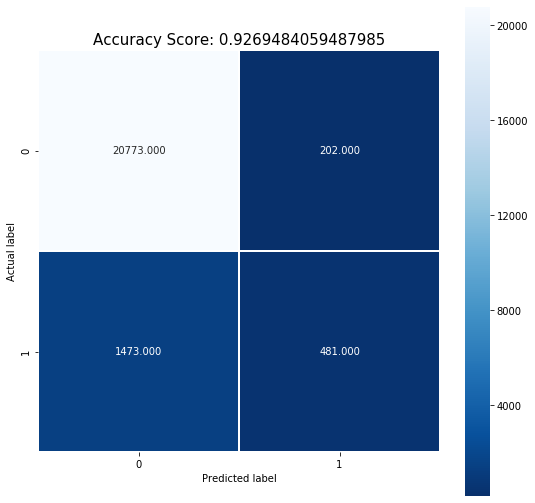

In [48]:
#Confusion Matrix (Seaborn)
#This is where we look at False positive, False negative etc. 

conf_matrix = metrics.confusion_matrix(y_test_encoded, predictions )


#this is awesome:  https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(testing_score)
plt.title(all_sample_title, size = 15);

In [ ]:
#now, lets train on the entire training set... 

#Fix Data Type for y
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y)
print(y_train_encoded)
print(utils.multiclass.type_of_target(y))
print(utils.multiclass.type_of_target(y.astype('int')))
print(utils.multiclass.type_of_target(y_train_encoded))

# Fit regression model
lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, \
                            class_weight=None, random_state=42, solver='lbfgs', max_iter=1000, multi_class='auto', \
                            verbose=0, warm_start=False, n_jobs=None)
model = lr
model.fit(X, y_train_encoded)
training_score = model.score(X, y_train_encoded)
print(f"Training Score: {training_score}")

In [ ]:
# #Grid search to select models and parameters for the model
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# #Love this:  https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5

# # Create first pipeline for base without reducing features.

# pipe = Pipeline([('classifier' , LogisticRegression())])

# # Create param grid.

# param_grid = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-4, 4, 20),
#     'classifier__solver' : ['liblinear']},
#     {'classifier' : [RandomForestClassifier()],
#     'classifier__n_estimators' : list(range(10,101,10)),
#     'classifier__max_features' : list(range(6,32,5))}
# ]

# # Create grid search object

# clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# # Fit on data

# best_clf = clf.fit(X_train, y_train_encoded)
# predictions =clf.predict(X_test)

# training_score = clf.score(X_train, y_train_encoded)
# testing_score = clf.score(X_test, y_test_encoded)

# print(clf.best_params_)

# print(clf.best_score_)

# print(f"Training Score: {training_score}")
# print(f"Testing Score: {testing_score}")

# #Confusion Matrix (Seaborn)
# #This is where we look at False positive, False negative etc. 

# conf_matrix = metrics.confusion_matrix(y_test_encoded, predictions )


# #this is awesome:  https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
# plt.figure(figsize=(9,9))
# sns.heatmap(conf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
# plt.ylabel('Actual label');
# plt.xlabel('Predicted label');
# all_sample_title = 'Accuracy Score: {0}'.format(testing_score)
# plt.title(all_sample_title, size = 15);

In [ ]:
#Need to use the best model... 

# Random Forest Classifier

In [49]:
# Fit regression model
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=25, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=42)
model = rf
model.fit(X_train, y_train_encoded)
predictions = model.predict(X_test)

training_score = model.score(X_train, y_train_encoded)
testing_score = model.score(X_test, y_test_encoded)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.9999418469411491
Testing Score: 0.9266867285969733


In [50]:
print(model.feature_importances_)

[0.04977739 0.04990065 0.07114791 0.03901769 0.03154589 0.0297519
 0.1018553  0.15622541 0.00284619 0.03375269 0.03026923 0.038362
 0.03706528 0.03531945 0.02488894 0.04067075 0.02297194 0.04374076
 0.03152241 0.03315002 0.03154862 0.03793213 0.01030182 0.00806157
 0.00837404]


In [51]:
# for feature, importance in dict(zip(train_features,model.feature_importances_)):
#     print(feature)

importances = dict(zip(train_features,model.feature_importances_))
for f, i in sorted(importances.items(), key = lambda item: item[1], reverse = True):
    print(f, i)

# best_features = []
# for f, i in sorted(importances.items(), key = lambda item: item[1], reverse = True):
#     if i > .009:
#         best_features.append(f)
        
# print(best_features)
        


apache_4a_hospital_death_prob 0.15622540797156922
h1_lactate_max 0.10185529811705643
patient_id 0.07114791031523438
encounter_id 0.04990065249986387
hospital_death 0.049777392209922125
d1_sysbp_min 0.04374076305036039
d1_sysbp_noninvasive_min 0.04067074954709074
d1_lactate_min 0.03901769383904891
d1_albumin_min 0.038361997764895545
d1_arterial_ph_min 0.037932128999280494
ph_apache 0.037065283260114344
d1_temp_min 0.035319448912409394
ventilated_apache 0.03375269433954451
h1_albumin_max 0.033150019174888634
h1_albumin_min 0.03154861570942131
d1_lactate_max 0.03154589309349596
d1_mbp_invasive_min 0.031522407711766544
fio2_apache 0.03026923399524716
h1_lactate_min 0.029751902183575336
h1_arterial_ph_max 0.024888943602124753
d1_spo2_min 0.022971940233533845
d1_sysbp_invasive_min 0.01030181922533483
gcs_eyes_apache 0.008374036225879225
gcs_verbal_apache 0.008061574569512961
apache_4a_icu_death_prob 0.0028461934488291964


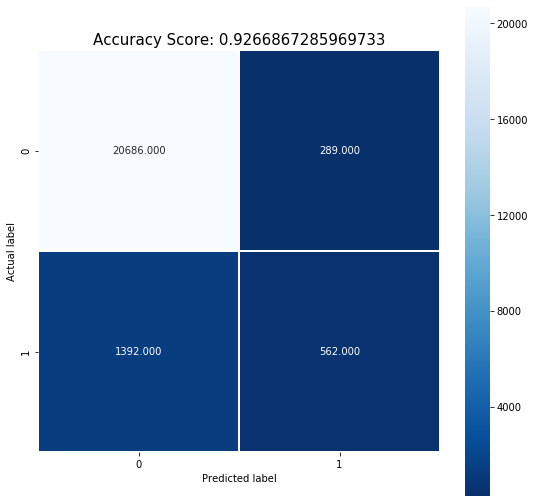

In [52]:
#Confusion Matrix (Seaborn)
#This is where we look at False positive, False negative etc. 

conf_matrix = metrics.confusion_matrix(y_test_encoded, predictions )


#this is awesome:  https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(testing_score)
plt.title(all_sample_title, size = 15);

In [53]:
#now, lets train on the entire training set... 

#Fix Data Type for y
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y)
print(y_train_encoded)
print(utils.multiclass.type_of_target(y))
print(utils.multiclass.type_of_target(y.astype('int')))
print(utils.multiclass.type_of_target(y_train_encoded))

# Fit regression model
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=25, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=42)
model = rf
model.fit(X_scaled, y_train_encoded)
predictions = model.predict(X_test)

training_score = model.score(X_scaled, y_train_encoded)

print(f"Training Score: {training_score}")

C:\Users\maden\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 0 0 ... 0 0 0]
binary
binary
binary
Training Score: 0.999945482101774


In [54]:
#Now we need to be able to get the prediction into the format needed for submittal
#add feature importances in here too, so that we can improve! 

In [55]:
print(target_col)

hospital_death


In [78]:
df_test = pd.DataFrame(df_test_scaled)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,-1.72,1.63,-0.08,-0.17,1.25e-02,3.41e-02,0.19,0.18,-0.72,-0.57,1.76,-6.44e-02,0.42,-0.21,-0.82,0.56,-0.83,0.06,9.52e-02,1.01e-01,0.06,-0.15,-2.13,-1.72,-0.43
1,-1.72,1.72,-0.04,-0.09,-8.06e-05,1.74e-02,0.02,-0.04,-0.72,-0.27,0.49,-1.07e-01,0.42,-0.05,-0.63,-0.02,-0.63,-0.07,2.74e-02,2.94e-02,0.03,-0.18,-0.08,0.51,0.40
2,-1.72,0.95,-0.09,-0.04,1.64e-02,5.01e-03,-0.23,-0.09,-0.72,-0.67,0.12,4.28e-03,-0.96,-0.21,0.29,0.46,0.29,0.89,2.30e-03,-2.63e-04,0.03,0.52,-2.13,-1.72,-0.43
3,-1.72,-0.46,-0.99,-1.16,-2.16e-01,-1.80e-01,0.44,0.59,1.39,1.29,-2.04,2.37e-02,1.54,0.46,-1.31,0.18,-1.31,-0.34,-4.83e+00,-4.81e+00,0.40,-0.89,-2.13,0.51,0.40
4,-1.72,-1.05,0.34,0.12,-1.75e-02,1.35e-02,1.74,1.73,1.39,0.91,1.34,1.41e-01,-0.33,0.14,-1.45,0.46,-1.46,-2.64,7.07e-02,8.52e-02,-0.12,-1.97,-2.13,-2.84,-1.25


In [79]:
#Make new prediction on the df_test data
#df_test[target_col] = model.predict(df_test_scaled)  #predicts 0 or 1
df_test[target_col] = model.predict_proba(df_test)[:,1] #probability prediction

In [80]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,hospital_death
0,-1.72,1.63,-0.08,-0.17,1.25e-02,3.41e-02,0.19,0.18,-0.72,-0.57,1.76,-6.44e-02,0.42,-0.21,-0.82,0.56,-0.83,0.06,9.52e-02,1.01e-01,0.06,-0.15,-2.13,-1.72,-0.43,0.22
1,-1.72,1.72,-0.04,-0.09,-8.06e-05,1.74e-02,0.02,-0.04,-0.72,-0.27,0.49,-1.07e-01,0.42,-0.05,-0.63,-0.02,-0.63,-0.07,2.74e-02,2.94e-02,0.03,-0.18,-0.08,0.51,0.40,0.12
2,-1.72,0.95,-0.09,-0.04,1.64e-02,5.01e-03,-0.23,-0.09,-0.72,-0.67,0.12,4.28e-03,-0.96,-0.21,0.29,0.46,0.29,0.89,2.30e-03,-2.63e-04,0.03,0.52,-2.13,-1.72,-0.43,0.10
3,-1.72,-0.46,-0.99,-1.16,-2.16e-01,-1.80e-01,0.44,0.59,1.39,1.29,-2.04,2.37e-02,1.54,0.46,-1.31,0.18,-1.31,-0.34,-4.83e+00,-4.81e+00,0.40,-0.89,-2.13,0.51,0.40,0.40
4,-1.72,-1.05,0.34,0.12,-1.75e-02,1.35e-02,1.74,1.73,1.39,0.91,1.34,1.41e-01,-0.33,0.14,-1.45,0.46,-1.46,-2.64,7.07e-02,8.52e-02,-0.12,-1.97,-2.13,-2.84,-1.25,0.44


In [81]:
#add the identifier "encounter_id" back in

df_test['encounter_id'] = identifiers_test['encounter_id']

In [82]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,hospital_death,encounter_id
0,-1.72,1.63,-0.08,-0.17,1.25e-02,3.41e-02,0.19,0.18,-0.72,-0.57,1.76,-6.44e-02,0.42,-0.21,-0.82,0.56,-0.83,0.06,9.52e-02,1.01e-01,0.06,-0.15,-2.13,-1.72,-0.43,0.22,2
1,-1.72,1.72,-0.04,-0.09,-8.06e-05,1.74e-02,0.02,-0.04,-0.72,-0.27,0.49,-1.07e-01,0.42,-0.05,-0.63,-0.02,-0.63,-0.07,2.74e-02,2.94e-02,0.03,-0.18,-0.08,0.51,0.40,0.12,5
2,-1.72,0.95,-0.09,-0.04,1.64e-02,5.01e-03,-0.23,-0.09,-0.72,-0.67,0.12,4.28e-03,-0.96,-0.21,0.29,0.46,0.29,0.89,2.30e-03,-2.63e-04,0.03,0.52,-2.13,-1.72,-0.43,0.10,7
3,-1.72,-0.46,-0.99,-1.16,-2.16e-01,-1.80e-01,0.44,0.59,1.39,1.29,-2.04,2.37e-02,1.54,0.46,-1.31,0.18,-1.31,-0.34,-4.83e+00,-4.81e+00,0.40,-0.89,-2.13,0.51,0.40,0.40,8
4,-1.72,-1.05,0.34,0.12,-1.75e-02,1.35e-02,1.74,1.73,1.39,0.91,1.34,1.41e-01,-0.33,0.14,-1.45,0.46,-1.46,-2.64,7.07e-02,8.52e-02,-0.12,-1.97,-2.13,-2.84,-1.25,0.44,10


In [83]:
#Convert encounter_id to int32
df_test['encounter_id'] = pd.to_numeric(df_test['encounter_id'],downcast = 'integer')

In [84]:
output = df_test[['encounter_id','hospital_death']]
output.head()

,encounter_id,hospital_death
0,2,0.22
1,5,0.12
2,7,0.10
3,8,0.40
4,10,0.44


In [85]:
df_test['encounter_id'].dtype

dtype('int32')

In [86]:
output.to_csv("../06_submissions/" + str(date.today()) + "_6" + ".csv", index=False)